In [1]:
import findspark
findspark.init()

import sys
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import pandas as pd

spark = SparkSession.builder.appName('Transport_Data').getOrCreate()

In [2]:
stops_df       = spark.read.csv('stops.txt',      header=True, inferSchema=True, sep=',')
stops_times_df = spark.read.csv('stop_times.txt', header=True, inferSchema=True, sep=',')
trips_df       = spark.read.csv('trips.txt',      header=True, inferSchema=True, sep=',')
routes_df      = spark.read.csv('routes.txt',     header=True, inferSchema=True, sep=',')
calender_df    = spark.read.csv('calendar.txt',   header=True, inferSchema=True, sep=',')
directions_df  = spark.read.csv('directions.txt', header=True, inferSchema=True, sep=',')

stops_df.createOrReplaceTempView("stops")
stops_times_df.createOrReplaceTempView("stops_times")
trips_df.createOrReplaceTempView("trips")
routes_df.createOrReplaceTempView("routes")
calender_df.createOrReplaceTempView("calender")
directions_df.createOrReplaceTempView("directions")

### Data Transformation, combining various datasets together

In [3]:
service_joined_data = spark.sql("""
SELECT stops.stop_id, stops.stop_code, stops.stop_name, stops.stop_lat, stops.stop_lon, stops.zone_id, stops.location_type,
       stops_times.trip_id, stops_times.arrival_time, stops_times.departure_time, stops_times.stop_sequence,
       stops_times.pickup_type, stops_times.drop_off_type, stops_times.shape_dist_traveled,
       trips.route_id, trips.service_id, trips.trip_headsign, trips.trip_short_name, trips.direction_id, 
       trips.block_id, trips.shape_id, trips.wheelchair_accessible, trips.bikes_allowed,
       routes.agency_id,routes.route_short_name,routes.route_long_name,routes.route_type,
       directions.direction,
       calender.monday,calender.tuesday,calender.wednesday,calender.thursday,calender.friday,
       calender.saturday,calender.sunday,calender.start_date,calender.end_date
FROM stops
LEFT JOIN stops_times ON stops.stop_id = stops_times.stop_id
LEFT JOIN trips ON stops_times.trip_id = trips.trip_id
LEFT JOIN routes ON trips.route_id = routes.route_id
LEFT JOIN directions ON trips.route_id = directions.route_id
LEFT JOIN calender ON trips.service_id = calender.service_id
""")
service_joined_data.createOrReplaceTempView("Complete_data")

In [4]:
Complete_routes = spark.sql("""SELECT trip_id,zone_id,
                                  arrival_time, departure_time,stop_id,stop_code,stop_name,stop_sequence, 
                                  stop_lat,stop_lon, route_id,route_long_name,direction,service_id,wheelchair_accessible,
                                  bikes_allowed,
                                  monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date 
                                  from Complete_data where trip_id is not null and route_id is not null """)
    
Complete_routes.createOrReplaceTempView("Transport_routes")

## Data Visualization of Key Metrics 

### Most Busiest Stops in Vancouver

In [5]:
busiest_stops = spark.sql("""
    SELECT stop_id, stop_name, stop_lat, stop_lon, count(distinct trip_id) as bus_frequency     
    FROM Transport_routes
    GROUP BY stop_id, stop_name, stop_lat, stop_lon
    ORDER BY bus_frequency desc """)
busiest_stops.show(10)

+-------+--------------------+---------+-----------+-------------+
|stop_id|           stop_name| stop_lat|   stop_lon|bus_frequency|
+-------+--------------------+---------+-----------+-------------+
|   3904|Coquitlam Central...|49.275476|-122.798723|         1953|
|  12600|UBC Exchange @ Un...|49.267674|-123.247621|         1863|
|     35|Waterfront Statio...|49.284786|-123.111191|         1857|
|     95|Westbound W Pende...|49.283818|-123.113429|         1720|
|  11616|Northbound Granvi...|49.284493|-123.114994|         1638|
|  11525|Northbound Granvi...|49.283461|-123.116549|         1638|
|  11523|Northbound Granvi...|49.282317|-123.118291|         1624|
|  11252|Marine Drive Stat...|49.209383|-123.116116|         1542|
|  11638|Westbound W Pende...|49.282472| -123.11137|         1465|
|  12406|Metrotown Station...| 49.22639|-123.004928|         1457|
+-------+--------------------+---------+-----------+-------------+
only showing top 10 rows



In [6]:
busiest_stops_pandas = busiest_stops.limit(100).toPandas() 

busiest_stops_map = folium.Map(location=[busiest_stops_pandas['stop_lat'].mean(), 
                                         busiest_stops_pandas['stop_lon'].mean()], zoom_start=12)
heat_data = busiest_stops_pandas[['stop_lat', 'stop_lon', 'bus_frequency']].values.tolist()
HeatMap(heat_data).add_to(busiest_stops_map)
for index, row in busiest_stops_pandas.iterrows():
    folium.Marker(location=[row['stop_lat'], row['stop_lon']], popup=row['stop_name']).add_to(busiest_stops_map)
    
busiest_stops_map

#Save Command to Save Map as HTML 
#busiest_stops_map.save("top_100_busiest_stops.html") 

### Number of Buses active during each hour of a day throughout the week

In [7]:
temporal_availability_query = spark.sql("""
    SELECT 'Monday' AS day_of_week, HOUR(arrival_time) AS hour_of_day, COUNT(*) AS num_trips
    FROM Transport_routes WHERE monday = 1 AND HOUR(arrival_time) IS NOT NULL 
    GROUP BY hour_of_day
    
    UNION ALL
    
    SELECT 'Tuesday' AS day_of_week, HOUR(arrival_time) AS hour_of_day, COUNT(*) AS num_trips
    FROM Transport_routes WHERE tuesday = 1 AND HOUR(arrival_time) IS NOT NULL 
    GROUP BY hour_of_day
    
    UNION ALL
    
    SELECT 'Wednesday' AS day_of_week, HOUR(arrival_time) AS hour_of_day, COUNT(*) AS num_trips
    FROM Transport_routes WHERE wednesday = 1 AND HOUR(arrival_time) IS NOT NULL 
    GROUP BY hour_of_day
    
    UNION ALL
    
    SELECT 'Thursday' AS day_of_week, HOUR(arrival_time) AS hour_of_day, COUNT(*) AS num_trips
    FROM Transport_routes WHERE thursday = 1 AND HOUR(arrival_time) IS NOT NULL 
    GROUP BY hour_of_day
    
    UNION ALL
    
    SELECT 'Friday' AS day_of_week, HOUR(arrival_time) AS hour_of_day, COUNT(*) AS num_trips
    FROM Transport_routes WHERE friday = 1 AND HOUR(arrival_time) IS NOT NULL 
    GROUP BY hour_of_day
    
    UNION ALL
    
    SELECT 'Saturday' AS day_of_week, HOUR(arrival_time) AS hour_of_day, COUNT(*) AS num_trips
    FROM Transport_routes WHERE saturday = 1 AND HOUR(arrival_time) IS NOT NULL 
    GROUP BY hour_of_day
    
    UNION ALL
    
    SELECT 'Sunday' AS day_of_week, HOUR(arrival_time) AS hour_of_day, COUNT(*) AS num_trips
    FROM Transport_routes WHERE sunday = 1 AND HOUR(arrival_time) IS NOT NULL 
    GROUP BY hour_of_day
    
    ORDER BY hour_of_day, day_of_week
""")
temporal_availability_query.show()


+-----------+-----------+---------+
|day_of_week|hour_of_day|num_trips|
+-----------+-----------+---------+
|     Friday|          3|      298|
|     Monday|          3|      298|
|   Saturday|          3|      296|
|     Sunday|          3|      292|
|   Thursday|          3|      298|
|    Tuesday|          3|      298|
|  Wednesday|          3|      298|
|     Friday|          4|     5592|
|     Monday|          4|     5592|
|   Saturday|          4|     1890|
|     Sunday|          4|     1622|
|   Thursday|          4|     5592|
|    Tuesday|          4|     5592|
|  Wednesday|          4|     5592|
|     Friday|          5|    39748|
|     Monday|          5|    39748|
|   Saturday|          5|    13282|
|     Sunday|          5|     8522|
|   Thursday|          5|    39748|
|    Tuesday|          5|    39748|
+-----------+-----------+---------+
only showing top 20 rows



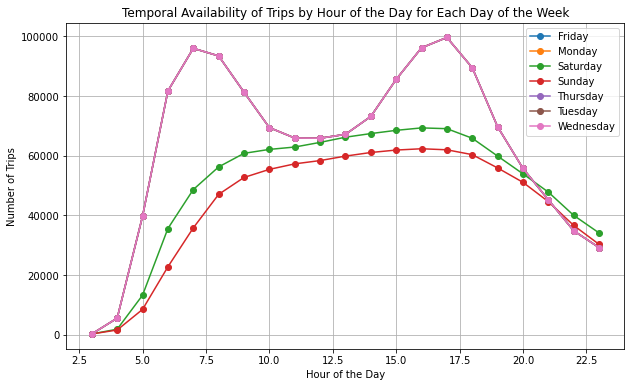

In [8]:
temporal_availability_pandas = temporal_availability_query.toPandas()

days = temporal_availability_pandas['day_of_week'].unique()
plt.figure(figsize=(10, 6))

for day in days:
    day_data = temporal_availability_pandas[temporal_availability_pandas['day_of_week'] == day]
    plt.plot(day_data['hour_of_day'], day_data['num_trips'], marker='o', label=day)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Temporal Availability of Trips by Hour of the Day for Each Day of the Week')
plt.legend()
plt.grid(True)
plt.show()


We can see only three line plots because the number of buses actively participating are same Monday to Friday

### Longest Bus Routes Connecting different Locations

In [9]:
top_longest_routes = spark.sql("""

SELECT distinct stop_id,stop_code,stop_name,stop_sequence, stop_lat,stop_lon, route_id, route_long_name, direction
 from Transport_routes 
 where (route_id,trip_id) in  
    (select distinct route_id, trip_id from
    (SELECT distinct route_id, route_long_name, max(trip_id) as trip_id, COUNT(distinct stop_id) AS num_stops
    FROM Transport_routes
    GROUP BY route_id, route_long_name,  direction
    ORDER BY num_stops DESC
    LIMIT 10))
        order by route_id, stop_sequence
""")
top_longest_routes.show()


+-------+---------+--------------------+-------------+---------+-----------+--------+---------------+---------+
|stop_id|stop_code|           stop_name|stop_sequence| stop_lat|   stop_lon|route_id|route_long_name|direction|
+-------+---------+--------------------+-------------+---------+-----------+--------+---------------+---------+
|  11793|    61701|UBC Exchange @ Ba...|            1| 49.26581|-123.248129|   16718|   Hastings/UBC|     EAST|
|  11793|    61701|UBC Exchange @ Ba...|            1| 49.26581|-123.248129|   16718|   Hastings/UBC|     WEST|
|    271|    50268|Eastbound Univers...|            2|49.266827|-123.241849|   16718|   Hastings/UBC|     WEST|
|    271|    50268|Eastbound Univers...|            2|49.266827|-123.241849|   16718|   Hastings/UBC|     EAST|
|   8013|    57938|Eastbound Univers...|            3|49.266503|-123.237822|   16718|   Hastings/UBC|     WEST|
|   8013|    57938|Eastbound Univers...|            3|49.266503|-123.237822|   16718|   Hastings/UBC|   

In [10]:
top_routes_pandas = top_longest_routes.toPandas()
route_colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'gray']

map_routes = folium.Map(location=[49.2827, -123.1207], zoom_start=12)

grouped_routes = top_routes_pandas.groupby('route_id')

color_index = 0
for route_id, group in grouped_routes:
    route_color = route_colors[color_index % len(route_colors)]  
    color_index += 1
    route_points = list(zip(group['stop_lat'], group['stop_lon']))
    folium.PolyLine(locations=route_points, color=route_color, weight=5, opacity=1, 
                    tooltip=f"Route ID: {route_id} - {group['route_long_name'].iloc[0]}").add_to(map_routes)

map_routes 
#Save Command to Save Map as HTML 
#map_routes.save("top_10_longest_routes_bold.html") 
